Mask Model
-------

Basing this on the fast.ai Keras Tiramisu implementation of the One Hundred Layers Tiramisu as described in Simon Jegou et al.'s paper [The One Hundred Layers Tiramisu: Fully Convolutional DenseNets for Semantic Segmentation](https://arxiv.org/abs/1611.09326).

This is heavily inspired by the code from the 2nd Fast.ai Deep Learning course here:
https://github.com/fastai/courses/blob/master/deeplearning2/tiramisu-keras.ipynb

I've updated it to Keras 2, but intend to rewrite it to make sure I understand it all.

In [1]:
%matplotlib inline
import bcolz
import glob
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Dropout, concatenate, Conv2DTranspose, Reshape
from keras.regularizers import l2
import numpy as np
import os
import random
import threading
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from PIL import Image
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def load_array(fname):
    return bcolz.open(fname)[:]

# FIXME rename dropout p -> rate or dropout_rate

def relu(x): 
    return Activation('relu')(x)
def dropout(x, p): 
    return Dropout(p)(x) if p else x
def bn(x): 
    return BatchNormalization(axis=-1)(x) # No longer can do mode=2
def relu_bn(x): 
    return relu(bn(x))

def conv(x, nf, sz, wd, p, stride=1):
    x = Conv2D(nf, (sz, sz), 
               padding="same", 
               kernel_initializer="he_uniform",
               strides=(stride,stride), 
               kernel_regularizer=l2(wd))(x)
    return dropout(x, p)

def conv_relu_bn(x, nf, sz=3, wd=0, p=0, stride=1):
    return conv(relu_bn(x), nf, sz, wd=wd, p=p, stride=stride)

def dense_block(n,x,growth_rate,p,wd):
    added = []
    for i in range(n):
        b = conv_relu_bn(x, growth_rate, p=p, wd=wd)
        x = concatenate([x, b])
        added.append(b)
    return x,added

def transition_dn(x, p, wd):
#     x = conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd)
#     return MaxPooling2D(strides=(2, 2))(x)
    return conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd, stride=2)

def down_path(x, nb_layers, growth_rate, p, wd):
    skips = []
    for i,n in enumerate(nb_layers):
        x,added = dense_block(n,x,growth_rate,p,wd)
        skips.append(x)
        x = transition_dn(x, p=p, wd=wd)
    return skips, added

def transition_up(added, wd=0):
    x = concatenate(added)
    _,r,c,ch = x.get_shape().as_list()
    return Conv2DTranspose(ch, (3, 3), 
                           strides=(2, 2), 
                           padding="same", 
                           kernel_initializer="he_uniform", 
                           kernel_regularizer=l2(wd))(x)
#     x = UpSampling2D()(x)
#     return conv(x, ch, 2, wd, 0)

def up_path(added, skips, nb_layers, growth_rate, p, wd):
    for i,n in enumerate(nb_layers):
        x = transition_up(added, wd)
        x = concatenate([x,skips[i]])
        x,added = dense_block(n,x,growth_rate,p,wd)
    return x

def reverse(a): 
    return list(reversed(a))

def create_tiramisu(nb_classes, img_input, nb_dense_block=6,
    growth_rate=16, nb_filter=48, nb_layers_per_block=5, p=None, wd=0):
    """
    nb_classes: number of classes
    img_input: tuple of shape (channels, rows, columns) or (rows, columns, channels)
    depth: number or layers
    nb_dense_block: number of dense blocks to add to end (generally = 3)
    growth_rate: number of filters to add per dense block
    nb_filter: initial number of filters
    nb_layers_per_block: number of layers in each dense block.
    If positive integer, a set number of layers per dense block.
    If list, nb_layer is used as provided
    p: dropout rate
    wd: weight decay
    """

    if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
        nb_layers = list(nb_layers_per_block)
    else: 
        nb_layers = [nb_layers_per_block] * nb_dense_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    skips,added = down_path(x, nb_layers, growth_rate, p, wd)
    x = up_path(added, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate, p, wd)

    x = conv(x, nb_classes, 1, wd, 0)
    _,r,c,f = x.get_shape().as_list()
    x = Reshape((-1, nb_classes))(x)
    return Activation('softmax')(x)

class image_generator(object):
    def __init__(self, X, Y, batch_size, channels):
        self.X  = X
        self.Y  = Y
        self.bs = batch_size
        self.i  = 0
    def __next__(self):
        xs = self.X[self.i:self.i+self.bs]
        ys = self.Y[self.i:self.i+self.bs]
        ys = ys.reshape(len(ys),-1,channels) # convert 32,64,64,1 -> 32,4096,1
        self.i = (self.i + self.bs) % self.X.shape[0]
        return xs, ys

Read in the training & validation images
-------

These are created via the mask_data_prep notebook

 - [ ] add testing of the test image set

In [3]:
# Remember to adjust 255 -> 1 on mask to convert it from a mask to a label
# 0=background, 1=inside staff
train_path = 'data/train'
train_score_image_names = glob.glob(train_path+'/diced_score*png')
train_mask_image_names = glob.glob(train_path+'/diced_mask*png')
train_score_image_names.sort()
train_mask_image_names.sort()
train_score_images = np.stack([np.array(Image.open(fn)) for fn in train_score_image_names])
train_mask_images = np.stack([np.array(Image.open(fn))//255 for fn in train_mask_image_names])
train_score_images.shape = train_score_images.shape + (1,)
train_mask_images.shape = train_mask_images.shape + (1,)
assert(train_score_images.shape == train_mask_images.shape)
num_train_images,rows,cols,channels = train_score_images.shape

In [4]:
valid_path = 'data/valid'
valid_score_image_names = glob.glob(valid_path+'/diced_score*png')
valid_mask_image_names = glob.glob(valid_path+'/diced_mask*png')
valid_score_image_names.sort()
valid_mask_image_names.sort()
valid_score_images = np.stack([np.array(Image.open(fn)) for fn in valid_score_image_names])
# adjust 255 -> 1 on mask
valid_mask_images = np.stack([np.array(Image.open(fn))//255 for fn in valid_mask_image_names])
valid_score_images.shape = valid_score_images.shape + (1,)
valid_mask_images.shape = valid_mask_images.shape + (1,)
assert(valid_score_images.shape == valid_mask_images.shape)
num_valid_images,_,_,_ = valid_score_images.shape

In [5]:
num_train_images, num_valid_images, rows, cols, channels

(1754, 584, 64, 64, 1)

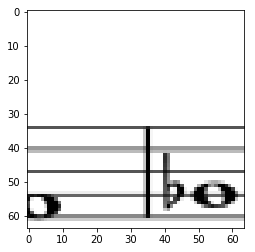

In [68]:
NNN=501
plt.imshow(train_score_images[NNN].reshape(64,64),cmap="gray")

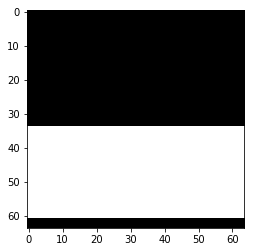

In [69]:
plt.imshow(train_mask_images[NNN].reshape(64,64),cmap="gray")

Make the Model & Do some Training
-----

Just a few epochs to see how things go.

In [22]:
input_shape = (rows,cols,channels)
batch_size  = 32
num_epochs  = 20
train_rate  = 1e-4
num_labels  = 2 

In [23]:
train_generator = image_generator(train_score_images, train_mask_images, batch_size, channels)
valid_generator = image_generator(valid_score_images, valid_mask_images, batch_size, channels)

In [24]:
image_input = Input(shape=input_shape)
x = create_tiramisu(num_labels, image_input, 
                    nb_layers_per_block=[4,5,7,10,12,15], 
                    p=0.2, wd=1e-4)
model = Model(image_input, x)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(train_rate), 
              metrics=["accuracy"])

In [25]:
model.fit_generator(train_generator, 
                    num_train_images//batch_size, num_epochs, 
                    verbose=2,
                    validation_data=valid_generator,
                    validation_steps=num_valid_images//batch_size)


Epoch 1/20
38s - loss: 11.0899 - acc: 0.3514 - val_loss: 11.1410 - val_acc: 0.3294
Epoch 2/20
32s - loss: 10.9127 - acc: 0.3562 - val_loss: 10.9368 - val_acc: 0.3515
Epoch 3/20
32s - loss: 10.7670 - acc: 0.3621 - val_loss: 10.9091 - val_acc: 0.3532
Epoch 4/20
32s - loss: 10.6393 - acc: 0.3684 - val_loss: 7.6373 - val_acc: 0.5500
Epoch 5/20
31s - loss: 3.6307 - acc: 0.7933 - val_loss: 1.4512 - val_acc: 0.9345
Epoch 6/20
31s - loss: 1.2234 - acc: 0.9497 - val_loss: 0.8745 - val_acc: 0.9730
Epoch 7/20
32s - loss: 0.9837 - acc: 0.9659 - val_loss: 0.7437 - val_acc: 0.9817
Epoch 8/20
32s - loss: 0.8285 - acc: 0.9757 - val_loss: 0.7250 - val_acc: 0.9811
Epoch 9/20
31s - loss: 0.7660 - acc: 0.9796 - val_loss: 0.6584 - val_acc: 0.9861
Epoch 10/20
31s - loss: 0.7029 - acc: 0.9832 - val_loss: 0.6142 - val_acc: 0.9891
Epoch 11/20
31s - loss: 0.6489 - acc: 0.9869 - val_loss: 0.5900 - val_acc: 0.9905
Epoch 12/20
32s - loss: 0.6206 - acc: 0.9883 - val_loss: 0.6310 - val_acc: 0.9871
Epoch 13/20
31s - 

Check results:
----

In [41]:
NNN=503
pred_result = model.predict(train_score_images[NNN:NNN+1])
pred_result = pred_result.reshape(1,64,64,2)
pred_zero,pred_one = pred_result[:,:,:,0], pred_result[:,:,:,1]

*results were prettty good here, but didn't save those cells.*

The edges were not straight so let's keep training... 

In [44]:
train_rate = 1e-5
num_epochs = 20
model.optimizer=keras.optimizers.RMSprop(train_rate, decay=1-0.9995)
model.fit_generator(train_generator, 
                    num_train_images//batch_size, num_epochs, 
                    verbose=2,
                    validation_data=valid_generator,
                    validation_steps=num_valid_images//batch_size)

Epoch 1/20
31s - loss: 0.4625 - acc: 0.9959 - val_loss: 0.4515 - val_acc: 0.9963
Epoch 2/20
30s - loss: 0.4586 - acc: 0.9957 - val_loss: 0.4457 - val_acc: 0.9961
Epoch 3/20
30s - loss: 0.4477 - acc: 0.9960 - val_loss: 0.4379 - val_acc: 0.9963
Epoch 4/20
30s - loss: 0.4336 - acc: 0.9966 - val_loss: 0.4149 - val_acc: 0.9976
Epoch 5/20
30s - loss: 0.4242 - acc: 0.9968 - val_loss: 0.4340 - val_acc: 0.9960
Epoch 6/20
30s - loss: 0.4149 - acc: 0.9970 - val_loss: 0.4179 - val_acc: 0.9963
Epoch 7/20
30s - loss: 0.4035 - acc: 0.9973 - val_loss: 0.3970 - val_acc: 0.9975
Epoch 8/20
30s - loss: 0.4025 - acc: 0.9969 - val_loss: 0.3875 - val_acc: 0.9980
Epoch 9/20
30s - loss: 0.3836 - acc: 0.9979 - val_loss: 0.3819 - val_acc: 0.9980
Epoch 10/20
30s - loss: 0.3825 - acc: 0.9973 - val_loss: 0.3820 - val_acc: 0.9975
Epoch 11/20
30s - loss: 0.3739 - acc: 0.9975 - val_loss: 0.3827 - val_acc: 0.9969
Epoch 12/20
30s - loss: 0.3608 - acc: 0.9982 - val_loss: 0.3682 - val_acc: 0.9972
Epoch 13/20
30s - loss: 0

In [71]:
NNN=505
pred_result = model.predict(train_score_images[NNN:NNN+1])
pred_result = pred_result.reshape(1,64,64,2)
pred_zero,pred_one = pred_result[:,:,:,0], pred_result[:,:,:,1]

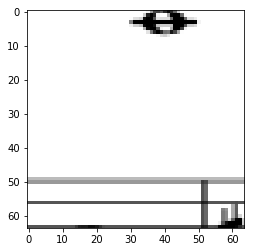

In [72]:
plt.imshow(train_score_images[NNN].reshape(64,64),cmap="gray")

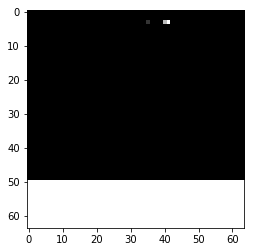

In [73]:
plt.imshow(pred_one.reshape(64,64),cmap="gray")

Nice Results
------------

Save those weights, but this wasn't much effort so let's keep going.

In [56]:
#!mkdir data/results
model.save_weights('data/results/mask_weights_171011_1.h5')

In [74]:
train_rate = 1e-5
num_epochs = 20
model.optimizer=keras.optimizers.RMSprop(train_rate, decay=1-0.9995)
model.fit_generator(train_generator, 
                    num_train_images//batch_size, num_epochs, 
                    verbose=2,
                    validation_data=valid_generator,
                    validation_steps=num_valid_images//batch_size)

Epoch 1/20
31s - loss: 0.2922 - acc: 0.9985 - val_loss: 0.2895 - val_acc: 0.9986
Epoch 2/20
30s - loss: 0.2829 - acc: 0.9989 - val_loss: 0.2914 - val_acc: 0.9980
Epoch 3/20
30s - loss: 0.2782 - acc: 0.9988 - val_loss: 0.3041 - val_acc: 0.9955
Epoch 4/20
30s - loss: 0.2725 - acc: 0.9986 - val_loss: 0.2792 - val_acc: 0.9976
Epoch 5/20
30s - loss: 0.2667 - acc: 0.9988 - val_loss: 0.2778 - val_acc: 0.9978
Epoch 6/20
30s - loss: 0.2609 - acc: 0.9989 - val_loss: 0.2765 - val_acc: 0.9972
Epoch 7/20
30s - loss: 0.2538 - acc: 0.9989 - val_loss: 0.2627 - val_acc: 0.9977
Epoch 8/20
30s - loss: 0.2443 - acc: 0.9992 - val_loss: 0.2606 - val_acc: 0.9970
Epoch 9/20
30s - loss: 0.2394 - acc: 0.9989 - val_loss: 0.2541 - val_acc: 0.9974
Epoch 10/20
30s - loss: 0.2323 - acc: 0.9991 - val_loss: 0.2521 - val_acc: 0.9970
Epoch 11/20
30s - loss: 0.2271 - acc: 0.9991 - val_loss: 0.2255 - val_acc: 0.9990
Epoch 12/20
30s - loss: 0.2175 - acc: 0.9993 - val_loss: 0.2165 - val_acc: 0.9990
Epoch 13/20
30s - loss: 0

In [210]:
model.save_weights('data/results/mask_weights_171011_2.h5')

In [83]:
NNN=1060
pred_result = model.predict(train_score_images[NNN:NNN+1])
pred_result = pred_result.reshape(1,64,64,2)
pred_zero,pred_one = pred_result[:,:,:,0], pred_result[:,:,:,1]

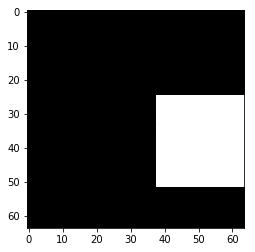

In [84]:
plt.imshow(pred_one.reshape(64,64),cmap="gray")

Let's use model
------

Read in full image, dice it up, predict output for each bit, reassemble into a full image.

In [211]:
def get_image_names(base_name):
    score_file_name = f'../data/{base_name}.png'
    mask_file_name = f'../data/{base_name}_mask.png'
    return score_file_name, mask_file_name

def get_images(base_name):
    score_file_name, mask_file_name = get_image_names(base_name)
    mask_image = Image.open(mask_file_name).convert('L')
    mask_image = Image.eval(mask_image, lambda x: x*10) # saturate the mask
    score_image = Image.open(score_file_name)
    background = Image.new('RGBA', score_image.size, (255,255,255))
    score_image = Image.alpha_composite(background,score_image)
    score_image = score_image.convert('L')
    return score_image, mask_image

In [227]:
def get_input_prediction_tiles(input_image):
    # cannot just send an image to predict.  We have to send the tiles
    # pred_result = model.predict(score_image)
    #   ValueError: Error when checking : expected input_1 to have shape (None, 64, 64, 1) 
    #   but got array with shape (1, 1123, 794, 1)
    num_tiles = np.ceil(np.array([input_image.width/64,input_image.height/64]))
    tot_tiles = int(num_tiles[0]*num_tiles[1])
    input_tiles = np.zeros((tot_tiles,64,64,1),dtype='uint8')
    i = 0
    for iy in range(int(num_tiles[1])):
        for ix in range(int(num_tiles[0])):
            input_tiles[i] = np.array(score_image.crop([ix*64,iy*64,(ix+1)*64,(iy+1)*64])).reshape(64,64,1)
            i += 1
    return input_tiles

def image_from_tiles(width,height,pred_tiles,pred_channel):
    # reshape & collect a single channel plane to visualize
    pred_tiles = pred_tiles.reshape(input_tiles.shape[0],64,64,2)
    pred_one_tiles = pred_tiles[:,:,:,1]#pred_one = pred_one.reshape(int(num_tiles[0])*64,int(num_tiles[1])*64)
    num_tiles = np.ceil(np.array([width/64,height/64]))
    pred_one = Image.new('L', (int(num_tiles[0])*64,int(num_tiles[1])*64), (0,))
    i = 0
    for iy in range(int(num_tiles[1])):
        for ix in range(int(num_tiles[0])):
            pred_tile_image = Image.fromarray(np.uint8(pred_one_tiles[i]*255))
            pred_one.paste(pred_tile_image, (ix*64,iy*64))
            i += 1
    return pred_one


In [228]:
score_image, mask_image = get_images('gen_two')
input_tiles = get_input_prediction_tiles(score_image)
pred_tiles = model.predict(input_tiles)
pred_one = image_from_tiles(score_image.width, score_image.height, pred_tiles, 1)

Visualize the output
----------

Look's likely to be acceptable!  There are definitely some glitches, but I think these are 
results that would work for finding the regions to focus on.

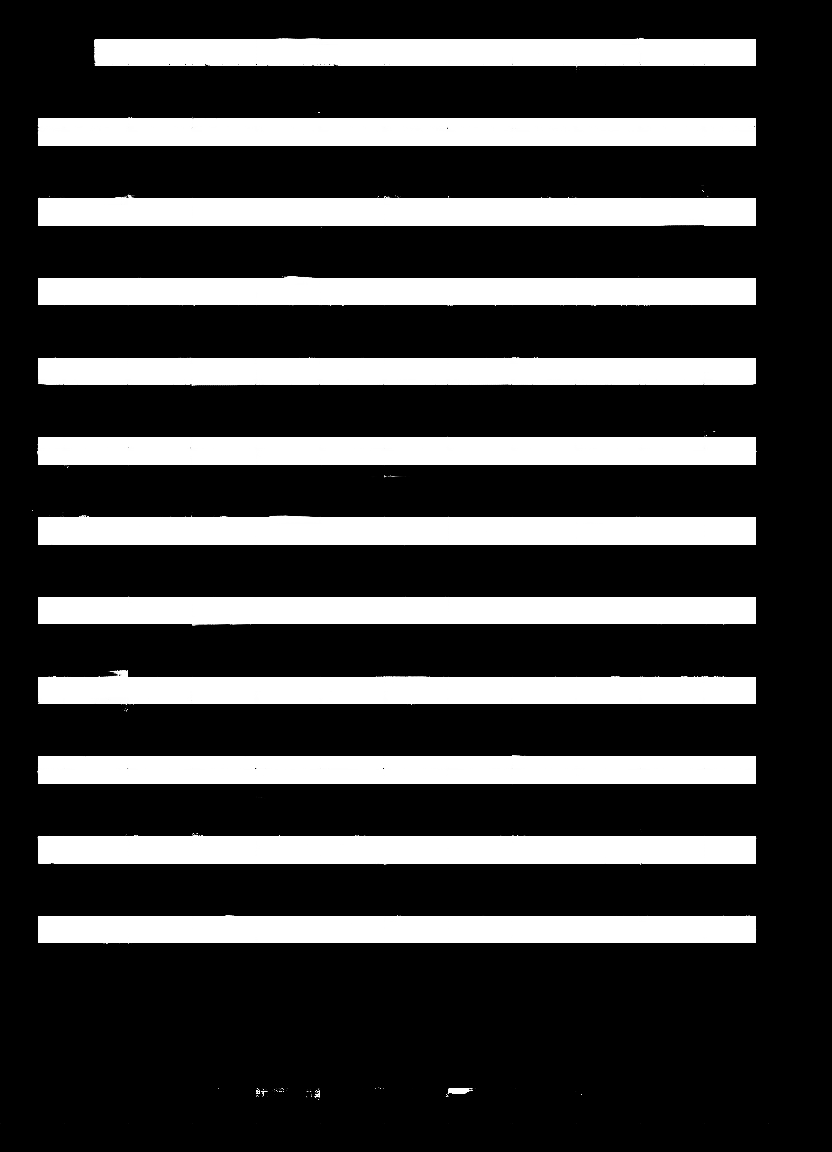

In [241]:
pred_one

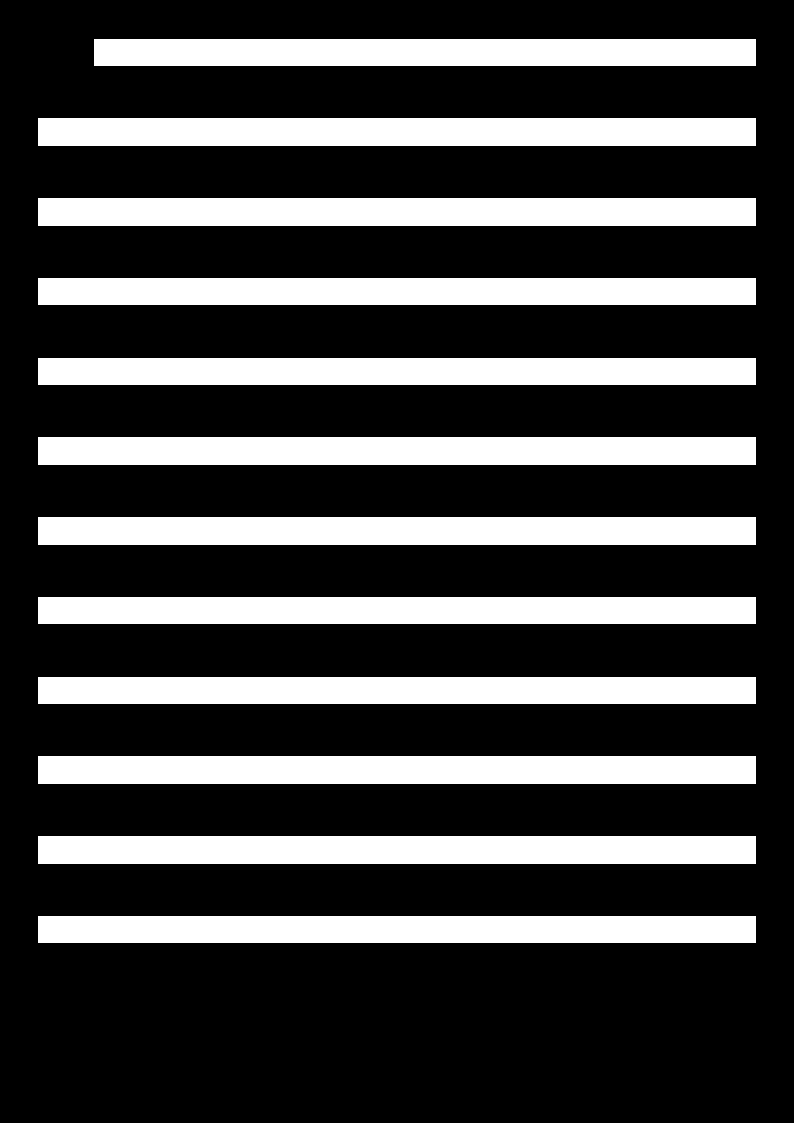

In [247]:
# for comparison, look at either of these...
#score_image
mask_image

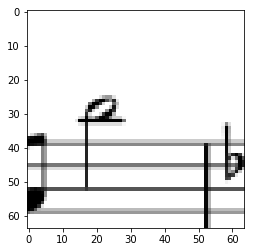

In [246]:
# just some debug snippets
ix, iy = 10, 0
img = np.array(score_image.crop([ix*64,iy*64,(ix+1)*64,(iy+1)*64])).reshape(64,64,1)
plt.imshow(img.reshape(64,64),cmap="gray")
#img[0,:10]

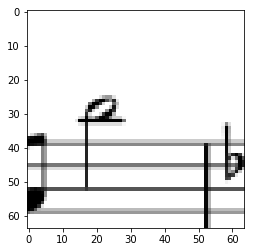

In [245]:
plt.imshow(input_tiles[10].reshape(64,64),cmap="gray")